<a href="https://colab.research.google.com/github/saisriy/ShroudX/blob/Jyothsna/texttoimagestego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
def Read_image(image_path) :
    image = Image.open(image_path)
    image = image.convert("RGB")
    pixels = image.load()
    return image,pixels

def Show_image(image) :
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def get_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

In [ ]:
def encode_message(image_path, message):
    image,pixels = Read_image(image_path)

    # Convert message to binary and add delimiter
    binary_message = ''.join(format(ord(char), '08b') for char in message)
    binary_message += '1111111111111110'  # Special delimiter to mark end

    width, height = image.size
    index = 0

    for y in range(height):
        for x in range(width):
            if index < len(binary_message):
                r, g, b = pixels[x, y]
                # Modify the least significant bit (LSB) of the red channel
                r = (r & ~1) | int(binary_message[index])
                pixels[x, y] = (r, g, b)
                index += 1

    return image



In [ ]:
def start_encode(image_path,message,output_path) :
  width, height = get_image_size(image_path)
  print(f"width {width} height {height}")
  char_can_be_stored= ((width*height)//8) - 2
  chars= len(message)
  print(f"chars_can_be_stored {char_can_be_stored}")
  print(f"chars_entered {chars}")
  encoded_image = encode_message(image_path, message)
  response= 'n'
  if response=='y' :
    # Save in PNG format to prevent compression artifacts
    encoded_image.save(output_path, "PNG")
    print(f"Stego image saved as {output_path}")

    # Download the image using Colab
    files.download(output_path)
  else :
   print("Image not saved")
  return encoded_image

width 256 height 256
chars_can_be_stored 8190
chars_entered 15
Image not saved


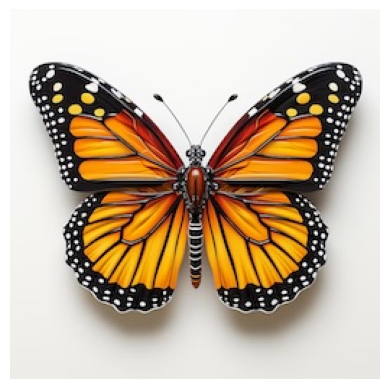

In [ ]:
image_path = "256_butter.jpg"
  # Replace with your actual image path
message = "Nori Pradeepika"
output_path= "butter_new.png"
encoded_image=start_encode(image_path, message, output_path)
Show_image(encoded_image)

In [ ]:
def decode_message(image_path):
    if isinstance(image_path, str):
        encoded_image = Image.open(image_path).convert("RGB")
    elif isinstance(image_path, Image.Image):
        encoded_image = image_path.convert("RGB")
    else:
        raise ValueError("Invalid input: Provide either an image file path or a PIL Image object")

    #encoded_image = Image.open(image_path).convert("RGB")
    pixels = encoded_image.load()
    width, height = encoded_image.size

    binary_message = ""

    for y in range(height):
        for x in range(width):
            r, _, _ = pixels[x, y]
            binary_message += str(r & 1)

    # Stop at delimiter
    if "1111111111111110" in binary_message:
        binary_message = binary_message.split("1111111111111110")[0]

    chars = [binary_message[i:i+8] for i in range(0, len(binary_message), 8)]
    message = ''.join(chr(int(char, 2)) for char in chars)

    return message




In [ ]:
# Use the downloaded stego image for decoding
#image_to_decode= encoded_image
decoded_message = decode_message(encoded_image)
print("Decoded Message:", decoded_message)

Decoded Message: Nori Pradeepika


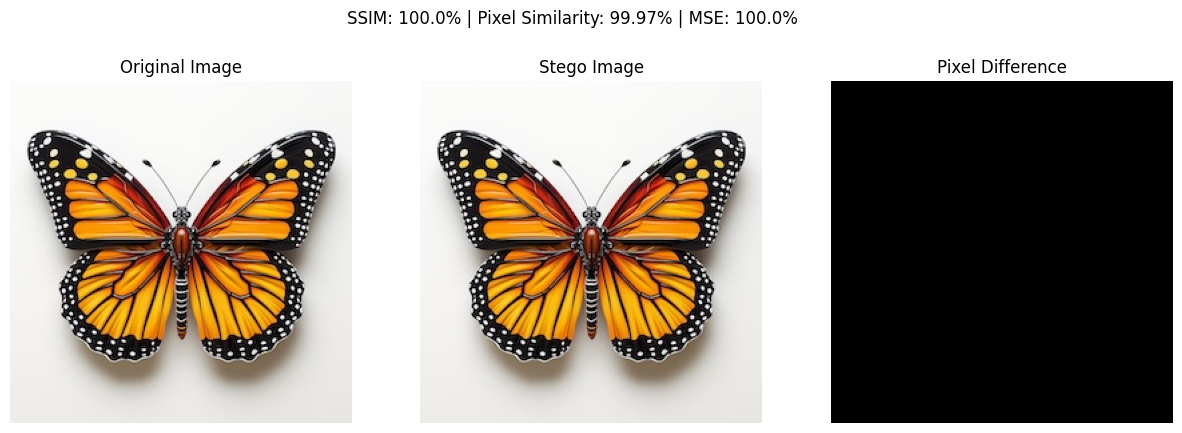

In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from PIL import Image

def pixel_difference(image1, image2):
    """Calculate the percentage of changed pixels between two images."""
    diff = cv2.absdiff(image1, image2)
    non_zero_count = np.count_nonzero(diff)
    total_pixels = image1.size

    similarity = ((total_pixels - non_zero_count) / total_pixels) * 100
    return round(similarity, 2), diff  # Return similarity score and difference image

def structural_similarity(image1, image2):
    """Compute SSIM for real-world similarity."""
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(gray1, gray2, full=True)
    return round(score * 100, 2)  # Convert to percentage

def mse_similarity(image1, image2):
    """Calculate Mean Squared Error (MSE) to measure image difference."""
    err = np.sum((image1.astype("float") - image2.astype("float")) ** 2)
    err /= float(image1.shape[0] * image1.shape[1] * image1.shape[2])

    return round(100 - (err / 255) * 100, 2)  # Convert MSE to percentage similarity

def load_image(image):
    """Load an image from path or convert to OpenCV format if needed."""
    if isinstance(image, str):
        img = cv2.imread(image)  # Load image as BGR
    elif isinstance(image, Image.Image):
        img = np.array(image)  # Convert PIL Image to NumPy
        if img.shape[-1] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)  # Convert RGBA → BGR
        elif img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB → BGR
    else:
        img = image  # Already a NumPy array

    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)  # Ensure uint8 format
    return img


def compare_images(image1, image2):
    """Load images, compute similarities, and display them side by side."""
    img1 = load_image(image1)
    img2 = load_image(image2)

    if img1 is None or img2 is None:
        print("Error: One or both images could not be loaded!")
        return

    if img1.shape != img2.shape:
        print("Error: Image dimensions do not match!")
        return

    # Compute similarity scores
    pixel_sim, diff_img = pixel_difference(img1, img2)
    ssim_score = structural_similarity(img1, img2)
    mse_score = mse_similarity(img1, img2)

    # Display images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Stego Image")
    ax[1].axis("off")

    ax[2].imshow(cv2.cvtColor(diff_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Pixel Difference")
    ax[2].axis("off")

    plt.suptitle(f"SSIM: {ssim_score}% | Pixel Similarity: {pixel_sim}% | MSE: {mse_score}%")
    plt.show()

# 🔹 Example Usage
image1 = "256_butter.jpg"  # File path # Returns NumPy array

compare_images(image1, encoded_image)  # ✅ Now it works correctly!